# Priprema za završni ispit - Upravljanje znanjem

Stvara se usmjereni graf korisnika s Twittera. Čvor grafa je korisnik Twittera, svaki čvor ima više pratitelja. Veze grafa su parovi (source, target).

In [20]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

nodes = pd.read_csv('nodes_df.csv')
edges = pd.read_csv('edges_df.csv')

### Veze

Lokalne mjere veza (nemaju težinu, sadrže samo parove čvorova)

In [21]:
es = edges.groupby('source').agg(neighbours_count=('source', 'size')).reset_index(drop=False)
es = es[es['neighbours_count'] > 16] # Filtriramo na korisnike koji imaju više od 16 pratitelja
edges = edges[
    (edges['source'].isin(es['source']) 
     & (edges['target'].isin(es['source'])))
]
edges

,source,target
19,1417058972947914752,1000540062
20,2743355546,1000540062
21,1332112269795319809,1000540062
22,246750632,1000540062
23,857762377,1000540062
...,...,...
304346,719493412517507072,999423708019163136
304347,67077504,999423708019163136
304348,759086769878994944,999423708019163136
304349,832164998453592064,999423708019163136


### Čvorovi

Lokalne mjere čvorova

In [22]:
nodes = nodes[nodes['user_id'].isin(es['source'])]
nodes['is_covid'] = nodes['covid_pct'].transform(lambda x: x >= 0.02)
nodes.reset_index(drop=True)

,user_id,total_tweets,covid_tweets,covid_pct,is_covid
0,7331,46,3,0.07,True
1,12667,90,1,0.01,False
2,664493,5,0,0.00,False
3,680383,2087,40,0.02,True
4,707093,661,40,0.06,True
...,...,...,...,...,...
3851,1481019813178839041,30,0,0.00,False
3852,1481945191930114048,83,4,0.05,True
3853,1482978509219840000,27,1,0.04,True
3854,1484626648607690761,28,2,0.07,True


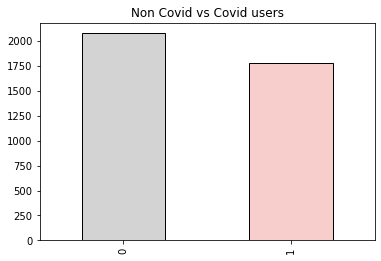

In [23]:
class_idx = {
    0: 0,
    1: 1
}
node_idx = {name: idx for idx, name in enumerate(sorted(nodes['user_id'].unique()))}

nodes['is_covid'] = nodes['is_covid'].apply(lambda value: class_idx[value])
edges['source'] = edges['source'].apply(lambda name: node_idx[name])
edges['target'] = edges['target'].apply(lambda name: node_idx[name])
nodes['user_id'] = nodes['user_id'].apply(lambda name: node_idx[name])

nodes.is_covid.value_counts().plot.bar(title='Non Covid vs Covid users', color=['#d3d3d3', '#f8cecc'], edgecolor='black')
plt.show()

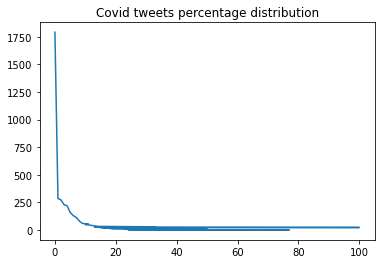

In [24]:
nodes.covid_pct.transform(lambda x: round(x, 2)*100).value_counts().plot(title='Covid tweets percentage distribution')
plt.show()

## Stvaranje networkx grafa

U početku učitavamo i prikazujemo sve čvorove.

In [26]:
def plot_graph(g):
    fig, ax = plt.subplots(1, figsize=(15, 15))
    color_groups = {
        0: '#d3d3d3',
        1: '#f8cecc'
    }

    covid_groups = nodes[nodes["user_id"].isin(g.nodes)]["is_covid"]
    covid_groups = covid_groups.transform(lambda x: color_groups[x])

    for label, c in color_groups.items():
        ax.plot([0],[0], color=c, label=label)
        
    nx.draw_spring(g, node_size=25, node_color=covid_groups, alpha=1)
    plt.legend(['Non Covid', 'Covid'])
    plt.show()

### Ispis neusmjerenog grafa sa svim vezama

Slika daje uvid u globalne mjere mreže poput:
- gustoća mreže ("na oko")
- broja čvorova (3 856)
- broja veza (252 027)

**Kompleksne mreže je teško vizualizirati zbog širokog raspona podataka**

<Figure size 1440x1440 with 0 Axes>

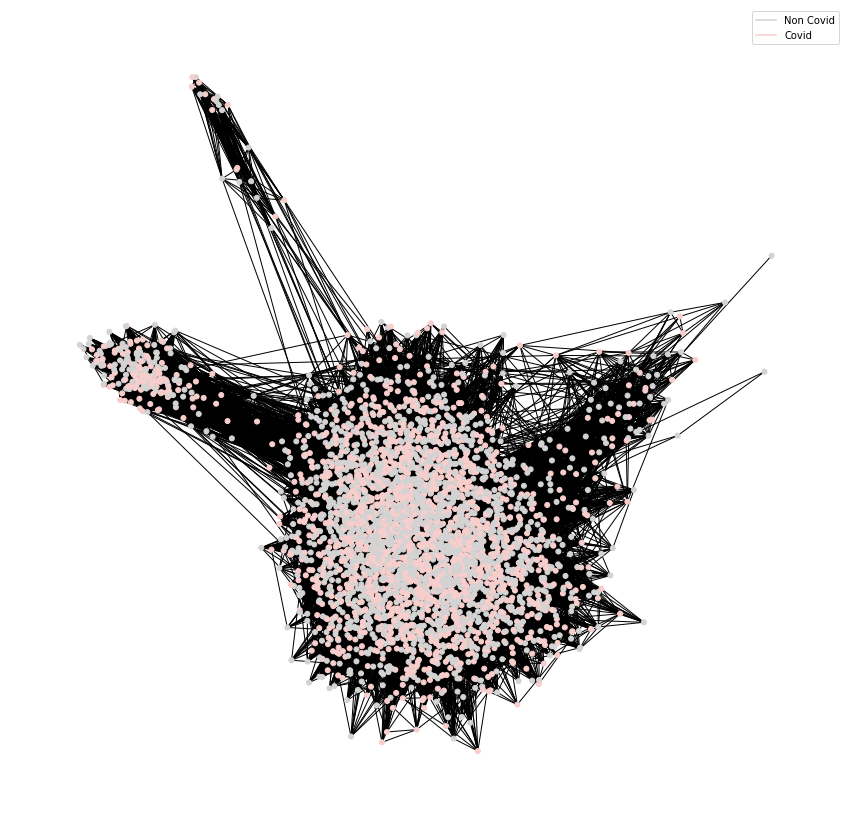

In [27]:
G = nx.from_pandas_edgelist(edges) # 252 027 veza
plt.figure(figsize=(20, 20))
plot_graph(G)

### Ispis usmjerenog grafa s 4000 veza

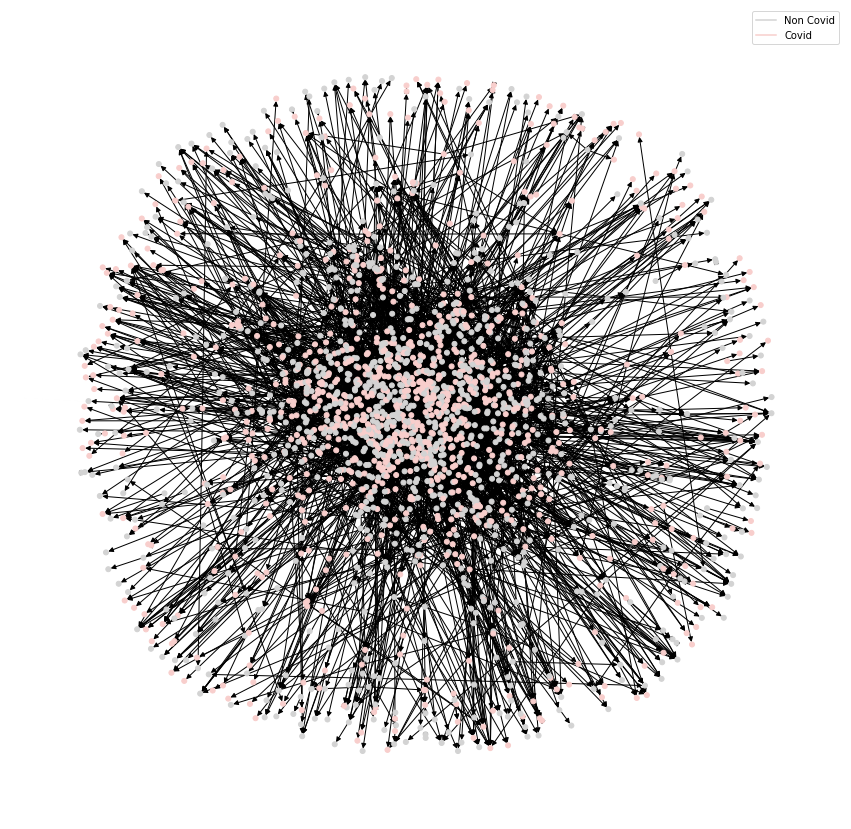

In [7]:
Di = nx.from_pandas_edgelist(edges.sample(4000), create_using=nx.DiGraph())
plot_graph(Di)

### Ispis neusmjerenog grafa s 1000 veza

<Figure size 1440x1440 with 0 Axes>

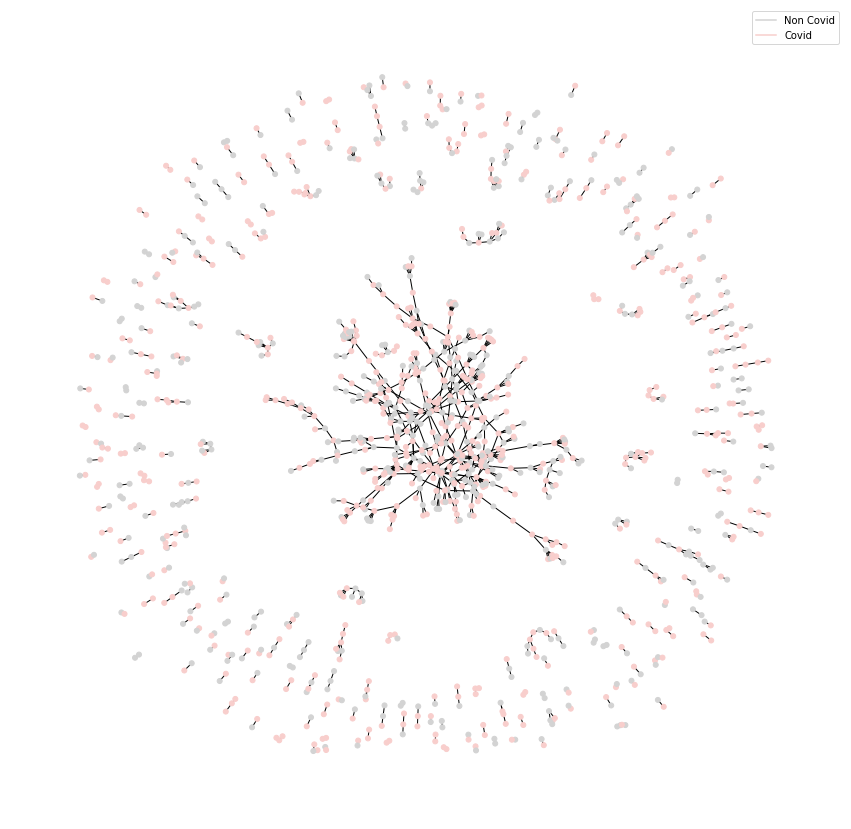

In [31]:
plt.figure(figsize=(20, 20))
plot_graph(nx.from_pandas_edgelist(edges.sample(1000)))

### Ispis usmjerenog grafa s 1000 čvorova

<Figure size 1440x1440 with 0 Axes>

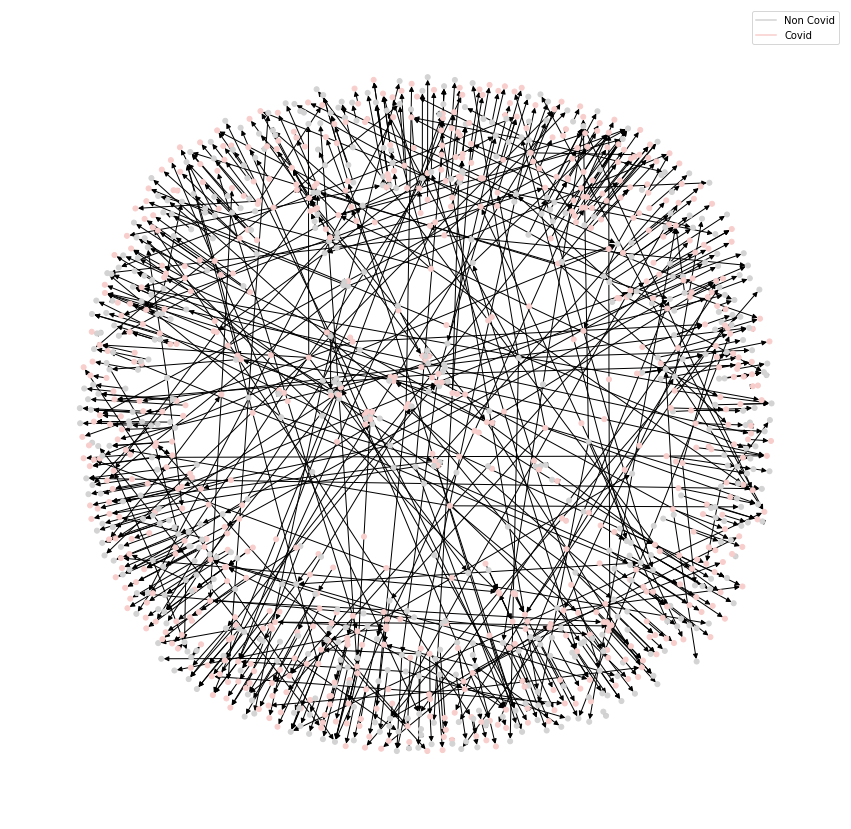

In [32]:
plt.figure(figsize=(20, 20))
plot_graph(nx.from_pandas_edgelist(edges.sample(1000), create_using=nx.DiGraph()))

# Informacije o grafu

1. Broj čvorova - broj čvorova u grafu
2. Broj veza - broj veza u grafu
3. Prosječni stupanj - prosječan broj veza svih čvorova
4. Gustoća mreže - omjer čvorova prisutnih u grafu i maksimalnog broja čvorova koje graf može sadržavati
5. Prosječna duljina najkraćeg puta - prosječna duljina svih najkraćih puteva iz jednog čvora u drugi
6. Koeficijent grupiranja - lokalna mjera čvora koja mjeri koliko je veza potrebno stvoriti do kompletnog grafa
7. Koeficijent asortativnosti - koliko se čvorovi povezuju sa sebi sličnim čvorovima u odnosu na različita svojstva
8. Dijametar mreže - duljina najdaljeg puta u grafu
9. Broj komponenti - broj povezanih komponenti u povezanom grafu
10. Izvorni čvor - čvor s najnižim stupnjem (brojem veza)
11. HUB (ponorni) čvor - čvor s najvećim stupnjem (brojem veza)

In [34]:
def get_average_degree(g):
    return sum(deg[1] for deg in g.degree()) / len(g.degree())


def get_clustering_coeff(G):
    largest_hubs = get_hub(G, max)
    largest_hub, degree = largest_hubs[0]
    return nx.clustering(G, largest_hub)


def get_hub(g, fn, limit=10):
    fn_degree = fn(deg[1] for deg in g.degree())
    return list(filter(lambda x: x[1] == fn_degree, g.degree()))[:limit]


def print_graph_info(g, is_connected=False):
    print('Broj čvorova (N)', g.number_of_nodes())
    print('Broj veza (K)', g.number_of_edges())
    print('Prosječni stupanj (<k>)', round(get_average_degree(g), 2))
    print('Gustoća mreže (d)', round(nx.density(g), 2))
    #print('Prosječna duljina najkraćeg puta (L)', round(get_avg_shortest_path(g), 2))
    
    print('Koeficijent grupiranja (c)', round(get_clustering_coeff(g), 2))
    print('Koeficijent asortativnosti (a)', round(nx.degree_assortativity_coefficient(g), 2))
    
    if is_connected:
        print('Dijametar mreže (D)', nx.diameter(g))
        print('Broj komponenti', nx.number_connected_components(g))
    
    print('HUB (ponorni čvor)', get_hub(g, fn=max))
    print('Izvorni čvor', get_hub(g, fn=min))
    

Di = nx.from_pandas_edgelist(edges, create_using=nx.DiGraph())
print_graph_info(Di)

Broj čvorova (N) 3856
Broj veza (K) 252027
Prosječni stupanj (<k>) 130.72
Gustoća mreže (d) 0.02
Koeficijent grupiranja (c) 0.08
Koeficijent asortativnosti (a) -0.04
HUB (ponorni čvor) [(1984, 1448)]
Izvorni čvor [(1295, 2)]


In [35]:
_Di = nx.complement(Di)
print_graph_info(_Di)

Broj čvorova (N) 3856
Broj veza (K) 14612853
Prosječni stupanj (<k>) 7579.28
Gustoća mreže (d) 0.98
Koeficijent grupiranja (c) 0.98
Koeficijent asortativnosti (a) nan
HUB (ponorni čvor) [(1295, 7708)]
Izvorni čvor [(1984, 6262)]


C:\Users\AndreaHrelja\anaconda3\envs\gnn\lib\site-packages\networkx\algorithms\assortativity\mixing.py:208: RuntimeWarning: invalid value encountered in true_divide
  a = a / a.sum()


In [30]:
#pd.read_csv('nodes_df.csv').astype(str).to_clipboard(index=False)